# Statistical Testing for Metabolomics Data in Cardiotoxicity Analysis

This Jupyter Notebook performs statistical tests (t-tests, ANOVA, and chi-square) on a metabolomics dataset to identify significant differences and associations related to cardiotoxicity. It complements machine learning models (Logistic Regression: 65%, Random Forest: 91%) by highlighting key metabolites and patterns for biomarker discovery.

## Objectives
- Perform t-tests to compare metabolite intensities between cardiotoxic and non-cardiotoxic groups.
- Use ANOVA to test differences in metabolite intensities across compounds or doses.
- Apply chi-square tests to examine associations between categorical variables (e.g., Effect vs. SampleType).
- Handle missing values and clean column names to ensure robust analysis.
- Visualize and interpret results to support biomarker discovery.

## Prerequisites
- R packages: `tidyverse`, `stats`, `ggplot2`, `broom`.
- Dataset: `A_Targeted_Metabolomics-Based_Assay_Using_Human_Induced_Pluripotent_Stem_Cell-Derived_Cardiomyocytes_rawdata.csv`.

## Notes
- Column names are cleaned with `make.names()` to avoid errors (e.g., `Arachidonic Acid` → `Arachidonic.Acid`).
- Missing values are handled with `na.omit`, with an option for imputation if data loss is high.
- This version fixes the t-test error (`grouping factor must have exactly 2 levels`) by ensuring `Effect` has two levels.
- Results can inform feature selection in modeling notebooks.

In [ ]:
# Load packages
library(tidyverse)
library(stats)
library(ggplot2)
library(broom)

print("Packages loaded successfully.")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


[1] "Packages loaded successfully."


## Step 1: Load and Prepare the Data

We load the dataset, pivot to wide format, clean column names, log-transform intensities, and handle missing values with `na.omit`. We ensure `Effect` has exactly two levels for t-tests.

In [3]:
# Load the dataset
data <- read.csv("/home/ilesh-dhall/Metabolomics-Biomarker-Discovery/data/A_Targeted_Metabolomics-Based_Assay_Using_Human_Induced_Pluripotent_Stem_Cell-Derived_Cardiomyocytes_rawdata.csv")

# Check for missing values in raw data
print("Missing values in raw data:")
colSums(is.na(data))

# Check unique values in Effect
print("Unique values in Effect (raw data):")
unique(data$Effect)
print("Distribution of Effect (raw data):")
table(data$Effect, useNA = "always")

# Pivot to wide format
data_wide <- data %>%
  mutate(sample_id = paste(Compound, Dose, SampleType, Well, sep = "_")) %>%
  pivot_wider(
    id_cols = c(sample_id, Effect, Compound, Dose, SampleType, Well),
    names_from = Metabolite,
    values_from = ApexIntensity,
    values_fn = mean
  )

# Clean column names to valid R names
names(data_wide) <- make.names(names(data_wide), unique = TRUE)

# Check column names and missing values
print("Column names in data_wide:")
colnames(data_wide)
print("Missing values in data_wide:")
missing_wide <- colSums(is.na(data_wide))
print(missing_wide)
print("Total rows with NA in data_wide:")
sum(complete.cases(data_wide) == FALSE)

# Standardize Effect column
data_wide <- data_wide %>%
  mutate(Effect = case_when(
    tolower(Effect) %in% c("cardiotoxic", "cardiotoxicity") ~ "Cardiotoxic",
    tolower(Effect) %in% c("non", "non-cardiotoxic", "noncardiotoxic") ~ "Non",
    TRUE ~ NA_character_
  )) %>%
  mutate(Effect = factor(Effect, levels = c("Non", "Cardiotoxic")))

# Check Effect after standardization
print("Unique values in Effect (data_wide):")
unique(data_wide$Effect)
print("Distribution of Effect (data_wide):")
table(data_wide$Effect, useNA = "always")

# Log-transform numeric columns
numeric_cols <- data_wide %>% select(where(is.numeric)) %>% names()
data_transformed <- data_wide %>%
  mutate(across(all_of(numeric_cols), ~log2(. + 1)))

# Remove rows with NA
print("Rows before na.omit:")
nrow(data_transformed)
data_clean <- na.omit(data_transformed)
print("Rows after na.omit:")
nrow(data_clean)

# Check Effect after na.omit
print("Unique values in Effect (data_clean):")
unique(data_clean$Effect)
print("Distribution of Effect (data_clean):")
table(data_clean$Effect, useNA = "always")

# Check class distribution and other variables
print("Class distribution (Effect):")
table(data_clean$Effect)
print("Distribution of SampleType:")
table(data_clean$SampleType)

# Check final data
head(data_clean)
dim(data_clean)

[1] "Missing values in raw data:"


Compound        Effect    Metabolite         Plate          Dose 
            0             0             0             0             0 
   SampleType          Well ApexIntensity 
            0             0             0

[1] "Unique values in Effect (raw data):"


[1] "Non"            "Cardiotoxic"    "SolventControl"

[1] "Distribution of Effect (raw data):"



   Cardiotoxic            Non SolventControl           <NA> 
         13857           6533           2504              0 

[1] "Column names in data_wide:"


[1] "sample_id"         "Effect"            "Compound"         
 [4] "Dose"              "SampleType"        "Well"             
 [7] "Arachidonic.Acid"  "X2..deoxycytidine" "Thymidine"        
[10] "Thymidine.D4"      "Lactate"           "Citrulline.D4"    
[13] "Lactate.D3"

[1] "Missing values in data_wide:"
        sample_id            Effect          Compound              Dose 
                0                 0                 0                 0 
       SampleType              Well  Arachidonic.Acid X2..deoxycytidine 
                0                 0                53                78 
        Thymidine      Thymidine.D4           Lactate     Citrulline.D4 
               58                55                69                61 
       Lactate.D3 
               52 
[1] "Total rows with NA in data_wide:"


[1] 381

[1] "Unique values in Effect (data_wide):"


[1] Non         Cardiotoxic <NA>       
Levels: Non Cardiotoxic

[1] "Distribution of Effect (data_wide):"



        Non Cardiotoxic        <NA> 
        956        1666           8 

[1] "Rows before na.omit:"


[1] 2630

[1] "Rows after na.omit:"


[1] 2241

[1] "Unique values in Effect (data_clean):"


[1] Non         Cardiotoxic
Levels: Non Cardiotoxic

[1] "Distribution of Effect (data_clean):"



        Non Cardiotoxic        <NA> 
        815        1426           0 

[1] "Class distribution (Effect):"



        Non Cardiotoxic 
        815        1426 

[1] "Distribution of SampleType:"



cells media 
 1585   656 

sample_id,Effect,Compound,Dose,SampleType,Well,Arachidonic.Acid,X2..deoxycytidine,Thymidine,Thymidine.D4,Lactate,Citrulline.D4,Lactate.D3
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Phenylphenol_100_cells_f11,Non,Phenylphenol,6.6582115,cells,f11,18.57674,10.873458,13.30700,15.80173,15.87417,14.67565,13.23297
Phenylphenol_0.3_cells_f6,Non,Phenylphenol,0.3785116,cells,f6,18.27375,12.270619,13.63042,15.59660,13.73960,14.58082,13.25315
Phenylphenol_10_media_h9,Non,Phenylphenol,3.4594316,media,h9,18.28493,9.552073,11.65570,15.68683,13.75410,14.63207,13.23325
Phenylphenol_10_cells_e9,Non,Phenylphenol,3.4594316,cells,e9,18.34441,12.108415,13.93914,15.82166,13.70185,14.58538,13.14911
Phenylphenol_100_cells_g11,Non,Phenylphenol,6.6582115,cells,g11,18.51324,11.219222,13.32391,15.83655,15.71990,14.64799,13.14607
Phenylphenol_100_cells_e11,Non,Phenylphenol,6.6582115,cells,e11,18.50284,11.281717,13.02825,15.43242,16.15572,14.66453,13.37167


[1] 2241   13

## Step 2: T-Tests for Metabolite Differences

We perform two-sample t-tests to compare metabolite intensities between `Effect` groups (Cardiotoxic vs. Non). Tests are run only if `Effect` has exactly two levels.

[1] "T-test results (all metabolites):"
# A tibble: 7 × 7
  Metabolite        estimate statistic  p.value conf.low conf.high p.adjusted
  <chr>                <dbl>     <dbl>    <dbl>    <dbl>     <dbl>      <dbl>
1 Arachidonic.Acid   -0.0437     -1.99 4.67e- 2  -0.0867 -0.000639   4.67e- 2
2 X2..deoxycytidine   0.284       3.83 1.33e- 4   0.138   0.429      1.86e- 4
3 Thymidine           0.179       3.95 8.04e- 5   0.0899  0.267      1.41e- 4
4 Thymidine.D4       -0.0373     -3.30 9.82e- 4  -0.0594 -0.0151     1.15e- 3
5 Lactate            -0.574     -11.2  3.46e-28  -0.675  -0.473      2.43e-27
6 Citrulline.D4      -0.186      -5.24 1.91e- 7  -0.256  -0.116      4.45e- 7
7 Lactate.D3         -0.252      -7.11 1.76e-12  -0.321  -0.182      6.16e-12
[1] "Significant metabolites (p.adjusted < 0.05):"
# A tibble: 7 × 7
  Metabolite        estimate statistic  p.value conf.low conf.high p.adjusted
  <chr>                <dbl>     <dbl>    <dbl>    <dbl>     <dbl>      <dbl>
1 Lactate      

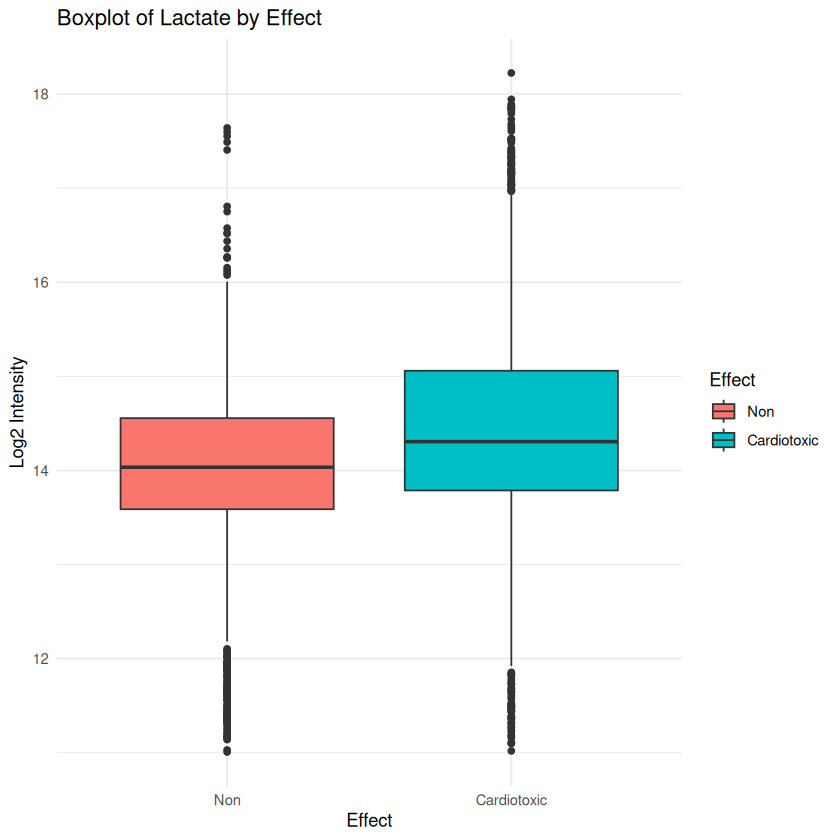

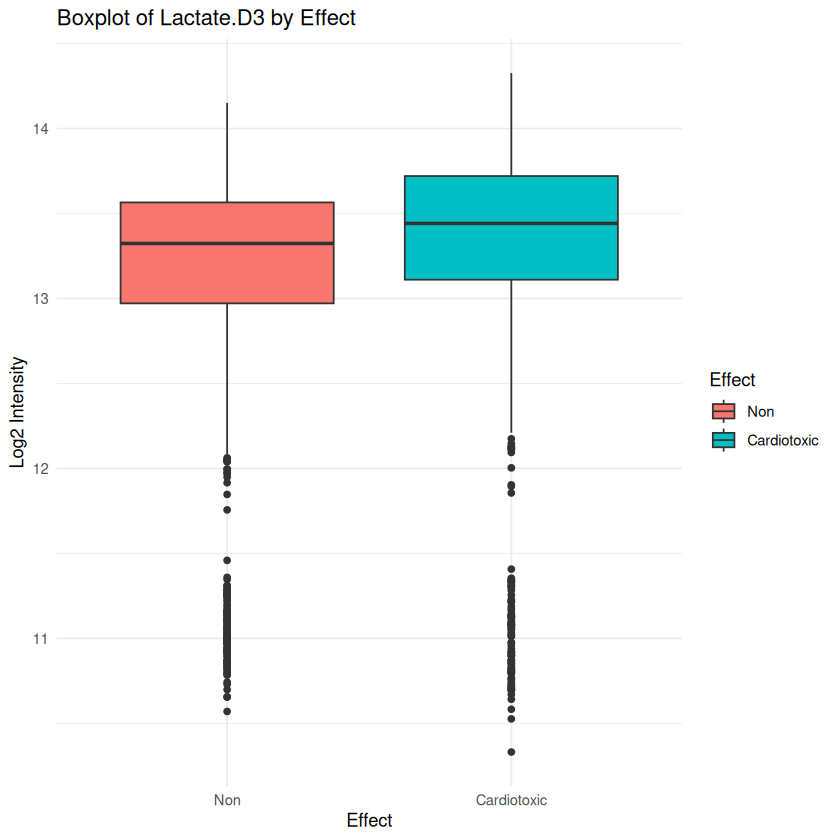

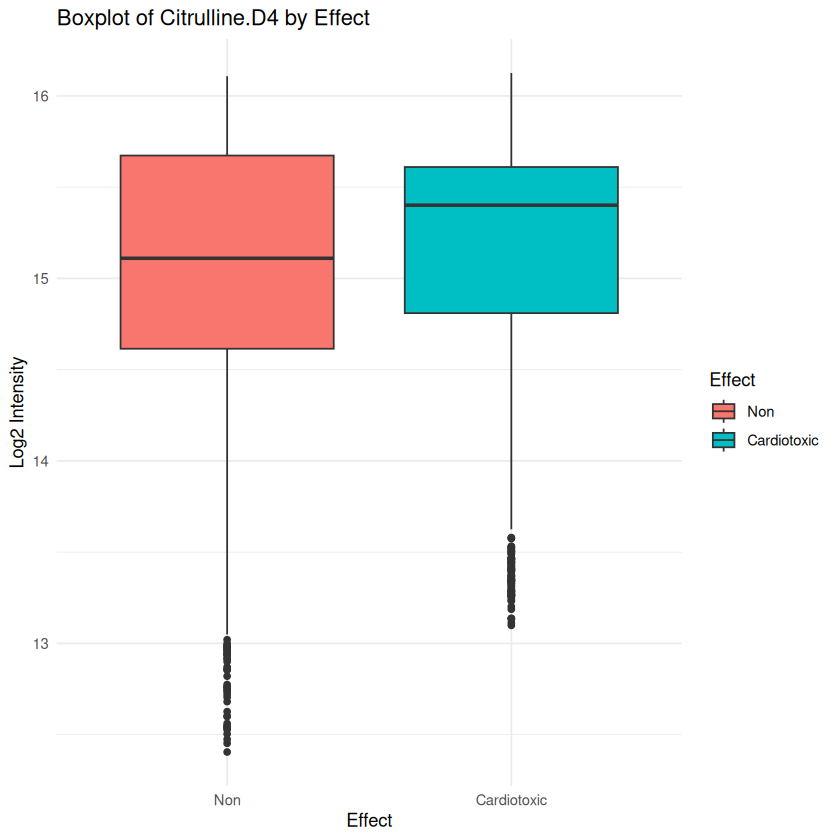

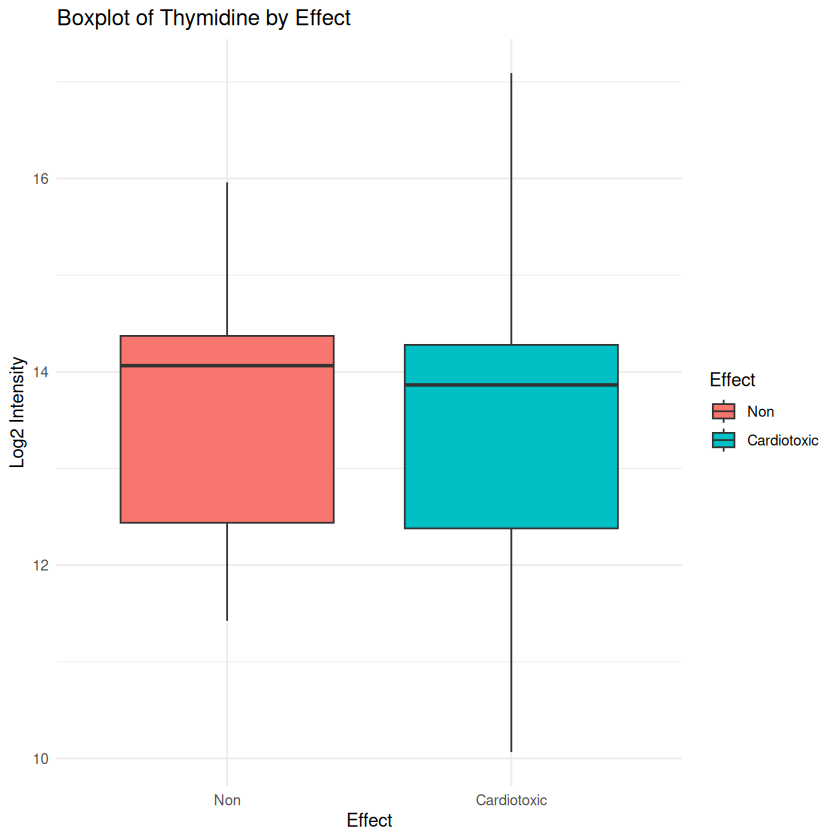

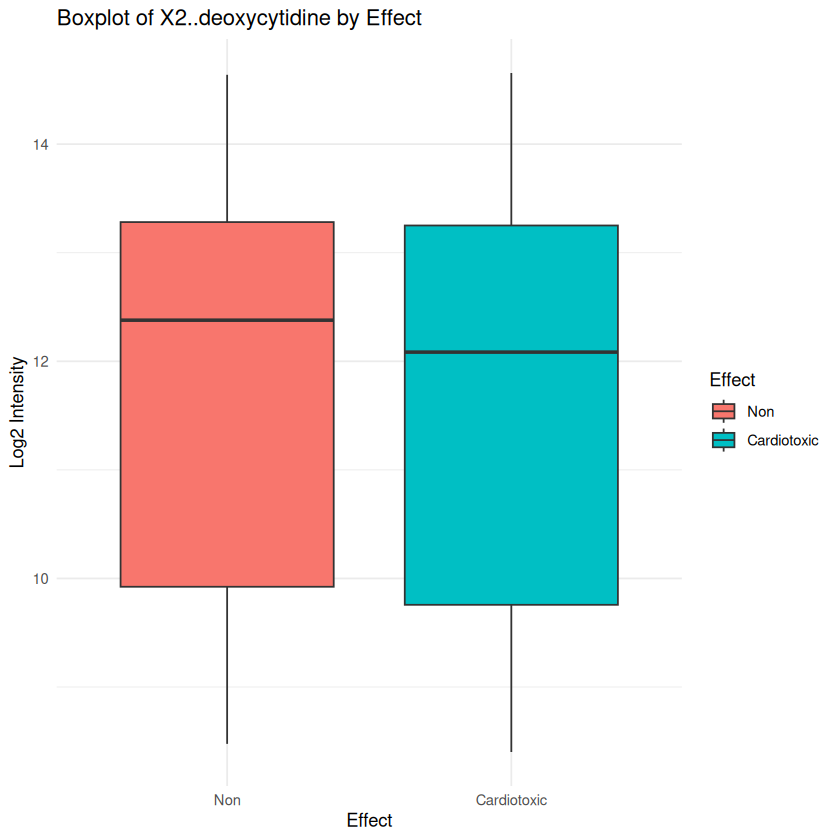

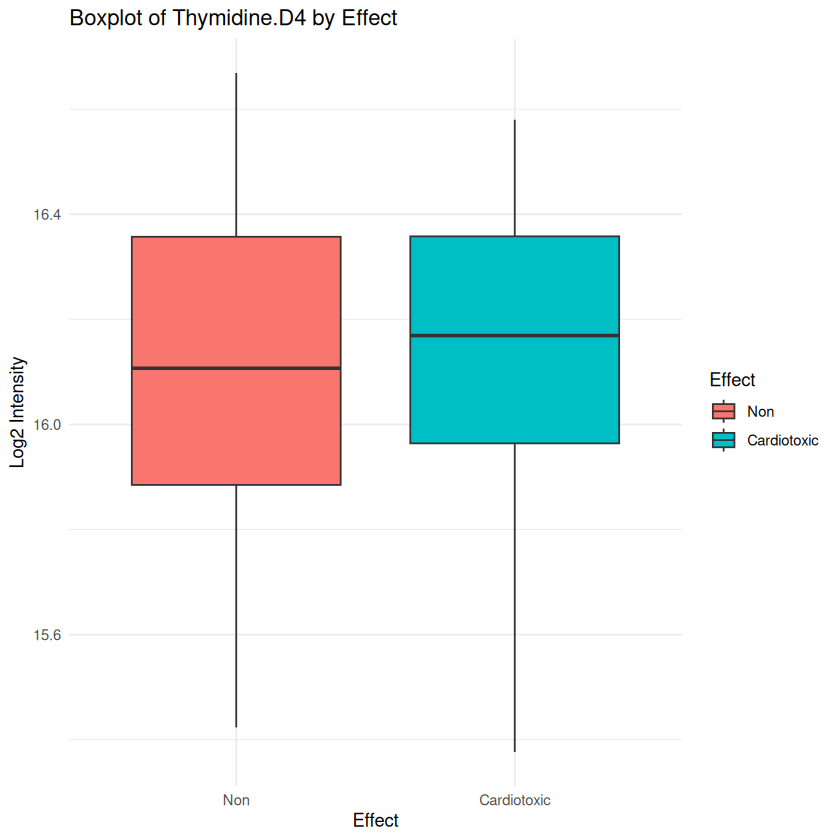

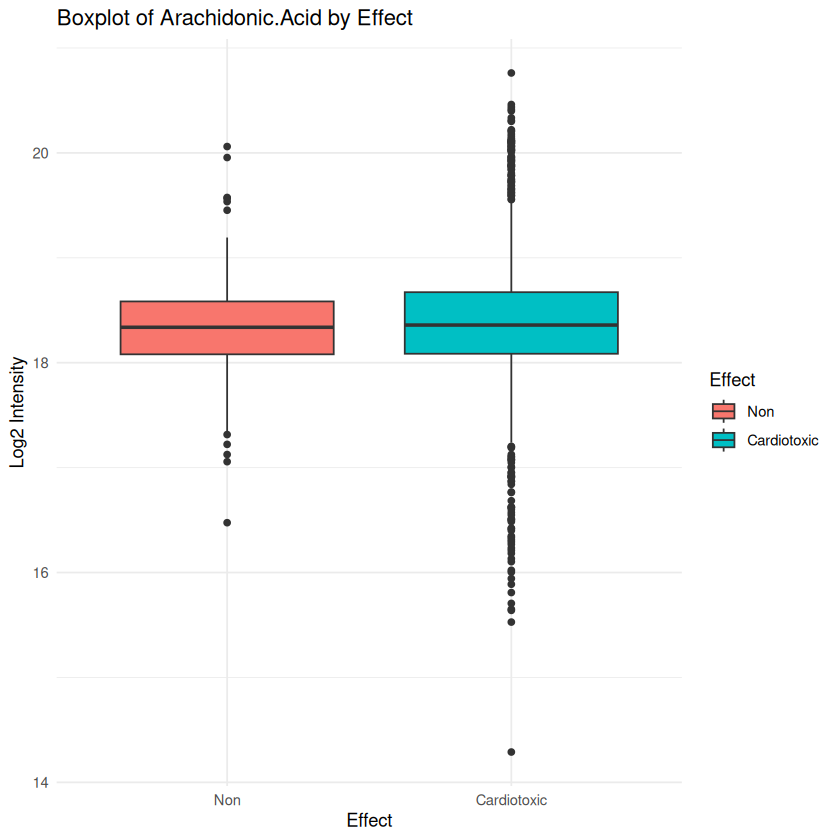

In [4]:
# Check if Effect has exactly two levels
effect_levels <- levels(data_clean$Effect)
if (length(effect_levels) == 2) {
  # Select metabolites (numeric columns except metadata)
  metabolites <- data_clean %>%
    select(where(is.numeric), -Dose) %>%
    names()

  # Perform t-tests for each metabolite
  t_test_results <- map_dfr(metabolites, function(met) {
    formula <- as.formula(paste(met, "~ Effect"))
    test <- t.test(formula, data = data_clean, var.equal = FALSE)  # Welch's t-test
    tidy(test) %>%
      mutate(Metabolite = met)
  }) %>%
    select(Metabolite, estimate, statistic, p.value, conf.low, conf.high) %>%
    mutate(p.adjusted = p.adjust(p.value, method = "BH"))  # Benjamini-Hochberg adjustment

  # Filter significant results (p.adjusted < 0.05)
  t_test_significant <- t_test_results %>%
    filter(p.adjusted < 0.05) %>%
    arrange(p.adjusted)

  # Print results
  print("T-test results (all metabolites):")
  print(t_test_results)
  print("Significant metabolites (p.adjusted < 0.05):")
  print(t_test_significant)

  # Visualize significant metabolites
  if (nrow(t_test_significant) > 0) {
    for (met in t_test_significant$Metabolite) {
      p <- ggplot(data_clean, aes(x = Effect, y = .data[[met]], fill = Effect)) +
        geom_boxplot() +
        labs(title = paste("Boxplot of", met, "by Effect"),
             y = "Log2 Intensity", x = "Effect") +
        theme_minimal()
      print(p)
    }
  } else {
    print("No significant metabolites found.")
  }
} else {
  print("Error: T-tests cannot be performed because Effect does not have exactly two levels.")
  print("Effect levels found:")
  print(effect_levels)
  print("Distribution of Effect in data_clean:")
  print(table(data_clean$Effect, useNA = "always"))
}

## Step 3: ANOVA for Metabolite Differences Across Groups

We perform one-way ANOVA to test differences in metabolite intensities across `Compound` or `Dose` levels. P-values are adjusted for multiple testing.

[1] "ANOVA results (Compound):"
# A tibble: 7 × 4
  Metabolite        statistic   p.value p.adjusted
  <chr>                 <dbl>     <dbl>      <dbl>
1 Arachidonic.Acid      15.6  4.39e-159  6.15e-159
2 X2..deoxycytidine      4.45 5.75e- 33  6.70e- 33
3 Thymidine              3.64 1.13e- 23  1.13e- 23
4 Thymidine.D4         195.   0          0        
5 Lactate               46.2  0          0        
6 Citrulline.D4        667.   0          0        
7 Lactate.D3           497.   0          0        
[1] "Significant metabolites (p.adjusted < 0.05):"
# A tibble: 7 × 4
  Metabolite        statistic   p.value p.adjusted
  <chr>                 <dbl>     <dbl>      <dbl>
1 Thymidine.D4         195.   0          0        
2 Lactate               46.2  0          0        
3 Citrulline.D4        667.   0          0        
4 Lactate.D3           497.   0          0        
5 Arachidonic.Acid      15.6  4.39e-159  6.15e-159
6 X2..deoxycytidine      4.45 5.75e- 33  6.70e- 33
7 Thymidine   

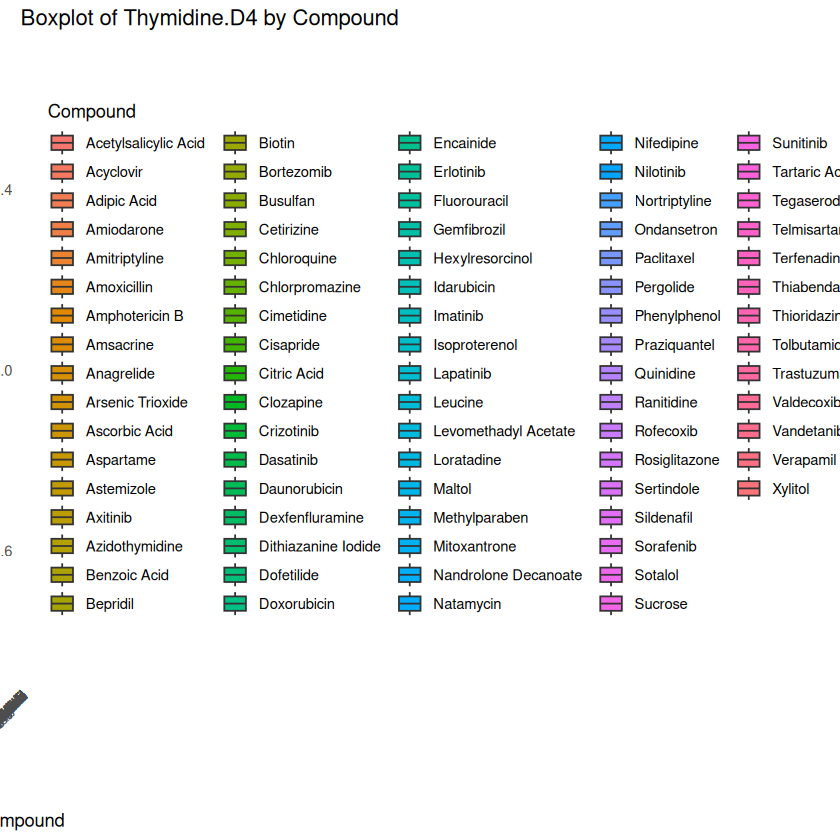

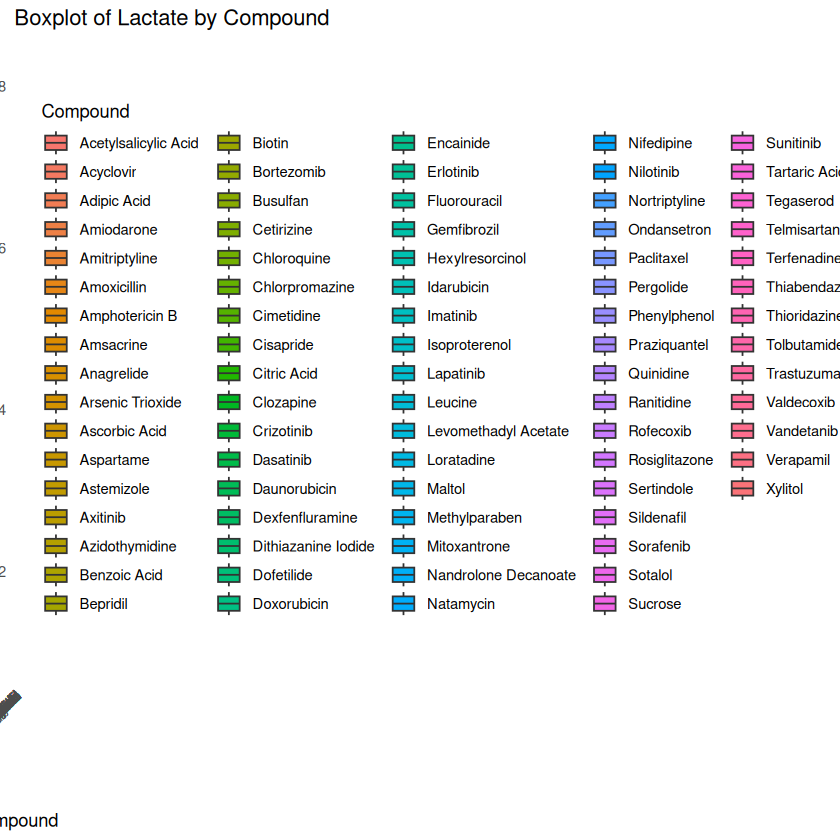

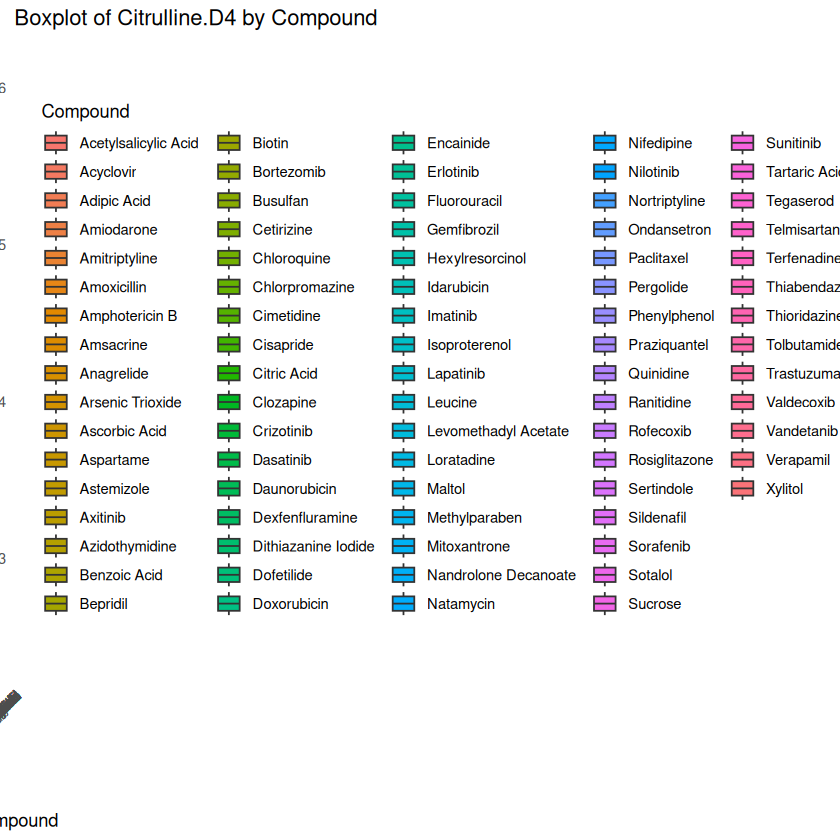

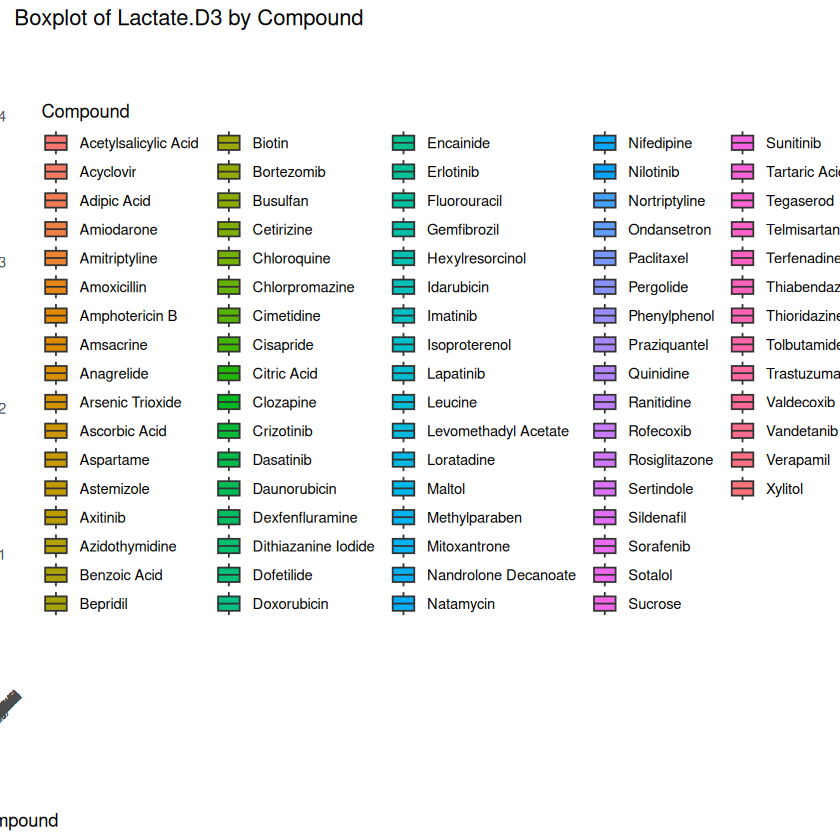

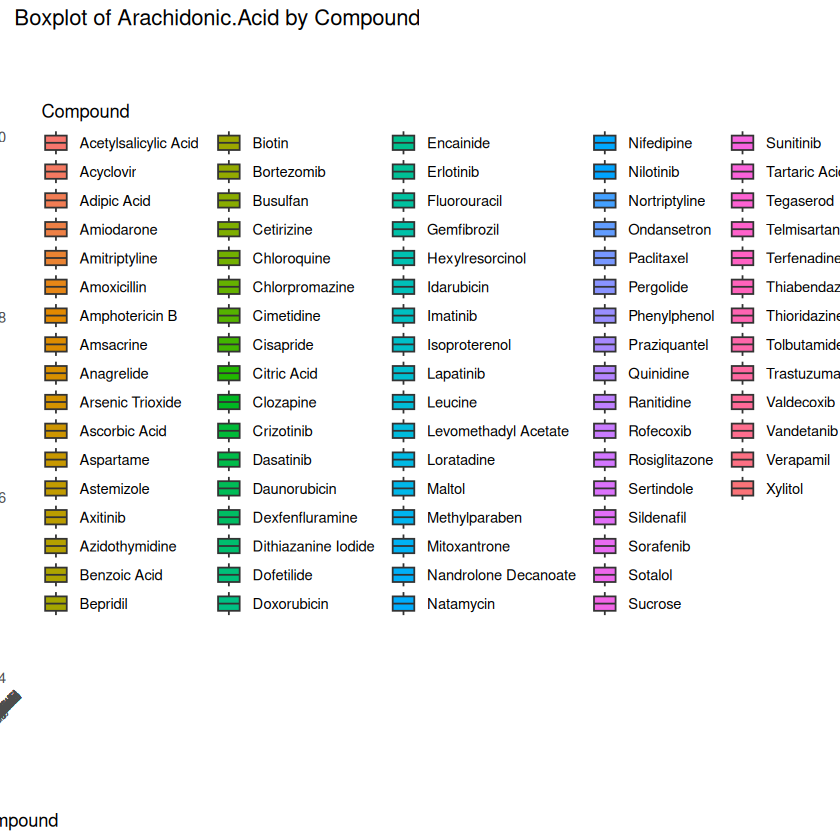

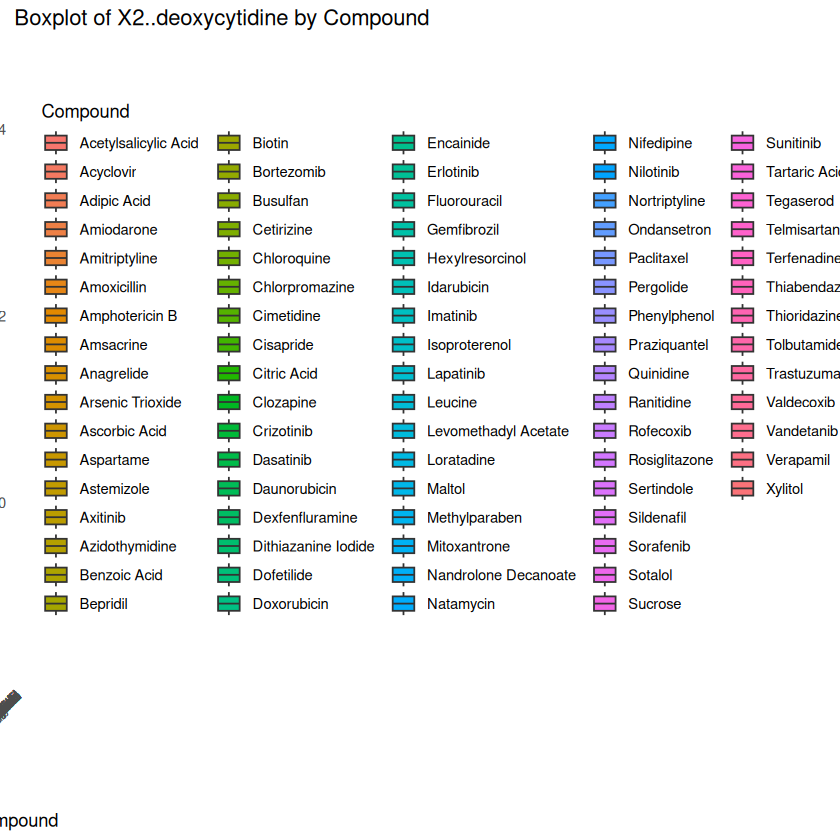

[1] "ANOVA results (Dose):"
# A tibble: 7 × 4
  Metabolite        statistic  p.value p.adjusted
  <chr>                 <dbl>    <dbl>      <dbl>
1 Arachidonic.Acid       3.44 6.83e- 7   9.56e- 7
2 X2..deoxycytidine      6.54 6.34e-17   2.22e-16
3 Thymidine              2.65 1.32e- 4   1.32e- 4
4 Thymidine.D4           5.45 2.71e-13   6.32e-13
5 Lactate                3.41 8.76e- 7   1.02e- 6
6 Citrulline.D4          6.83 6.61e-18   4.63e-17
7 Lactate.D3             4.15 4.40e- 9   7.70e- 9
[1] "Significant metabolites (p.adjusted < 0.05):"
# A tibble: 7 × 4
  Metabolite        statistic  p.value p.adjusted
  <chr>                 <dbl>    <dbl>      <dbl>
1 Citrulline.D4          6.83 6.61e-18   4.63e-17
2 X2..deoxycytidine      6.54 6.34e-17   2.22e-16
3 Thymidine.D4           5.45 2.71e-13   6.32e-13
4 Lactate.D3             4.15 4.40e- 9   7.70e- 9
5 Arachidonic.Acid       3.44 6.83e- 7   9.56e- 7
6 Lactate                3.41 8.76e- 7   1.02e- 6
7 Thymidine              2.65 1.32e

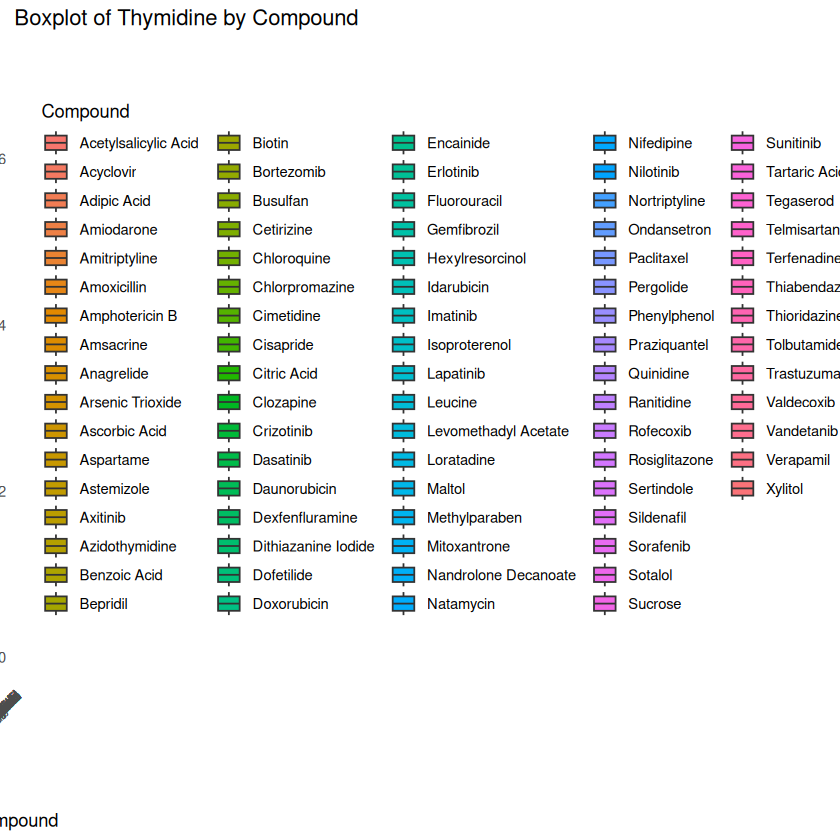

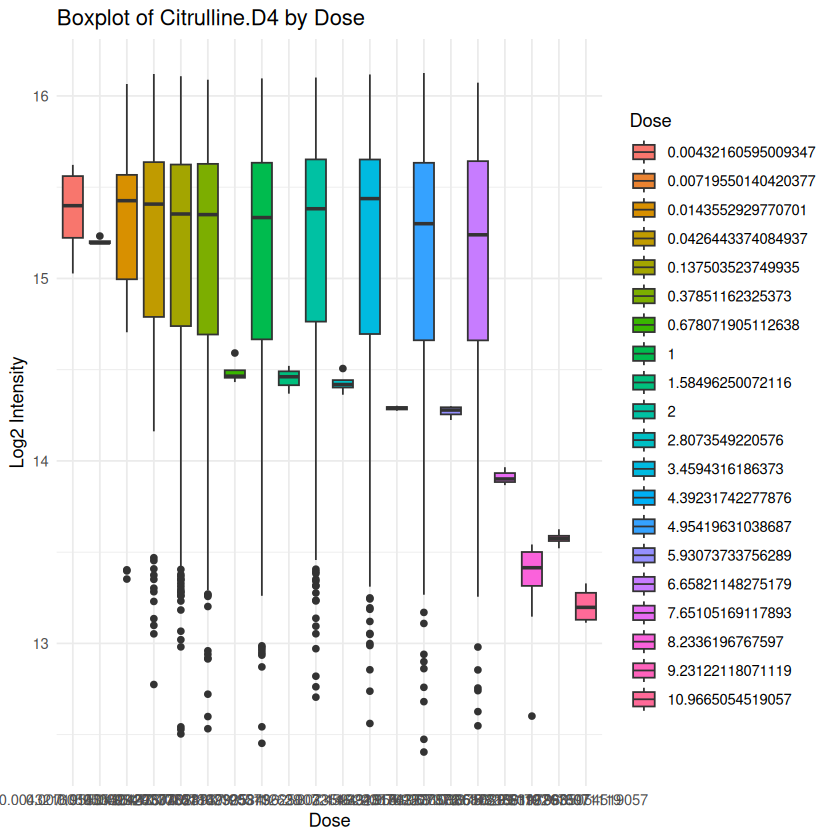

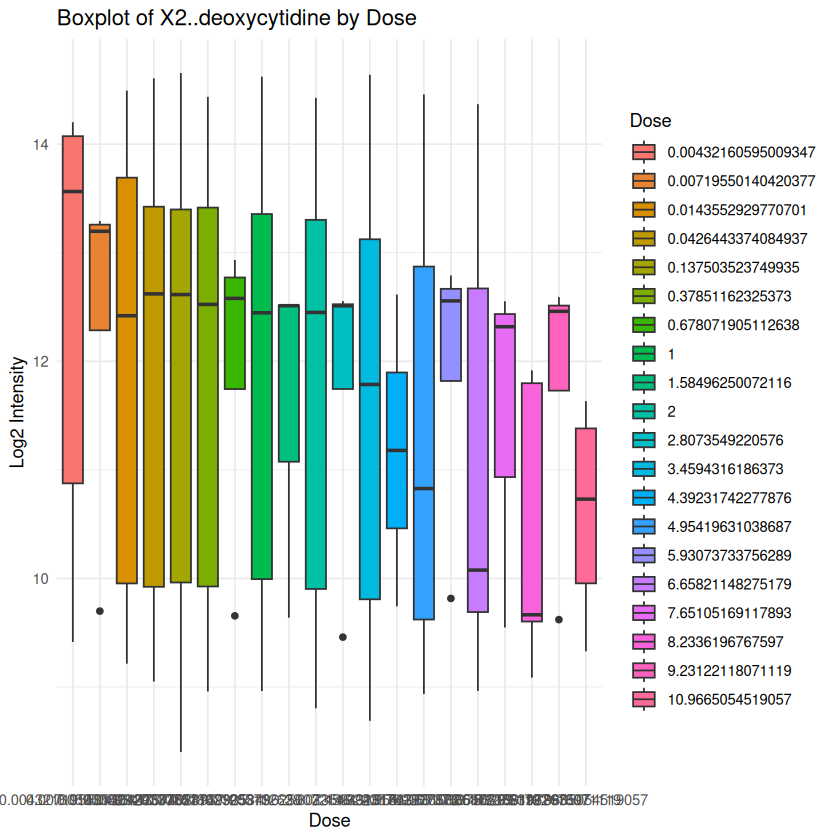

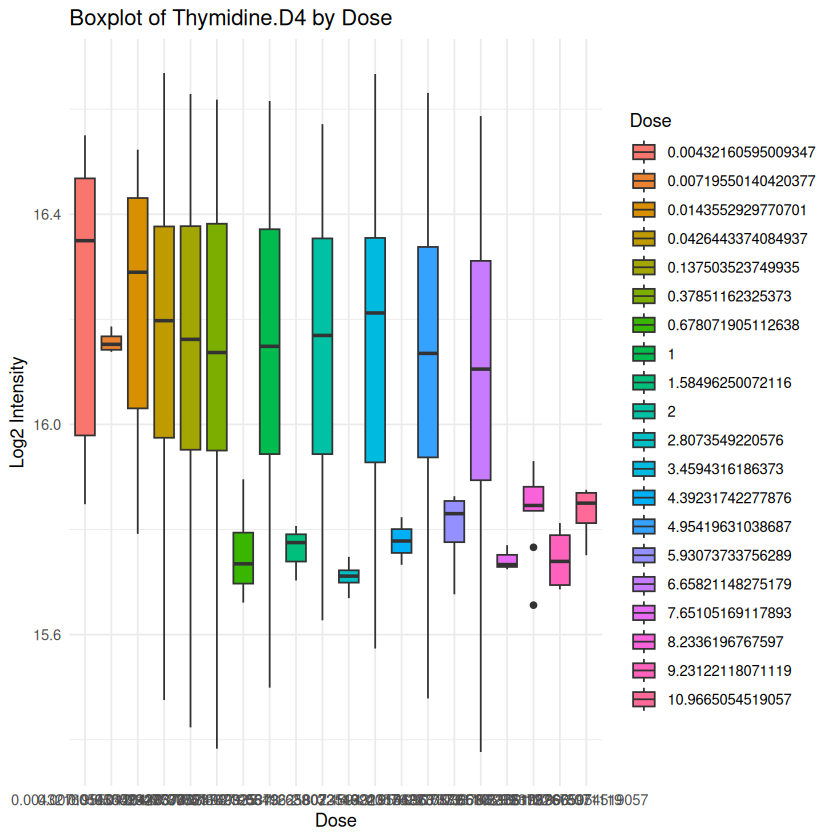

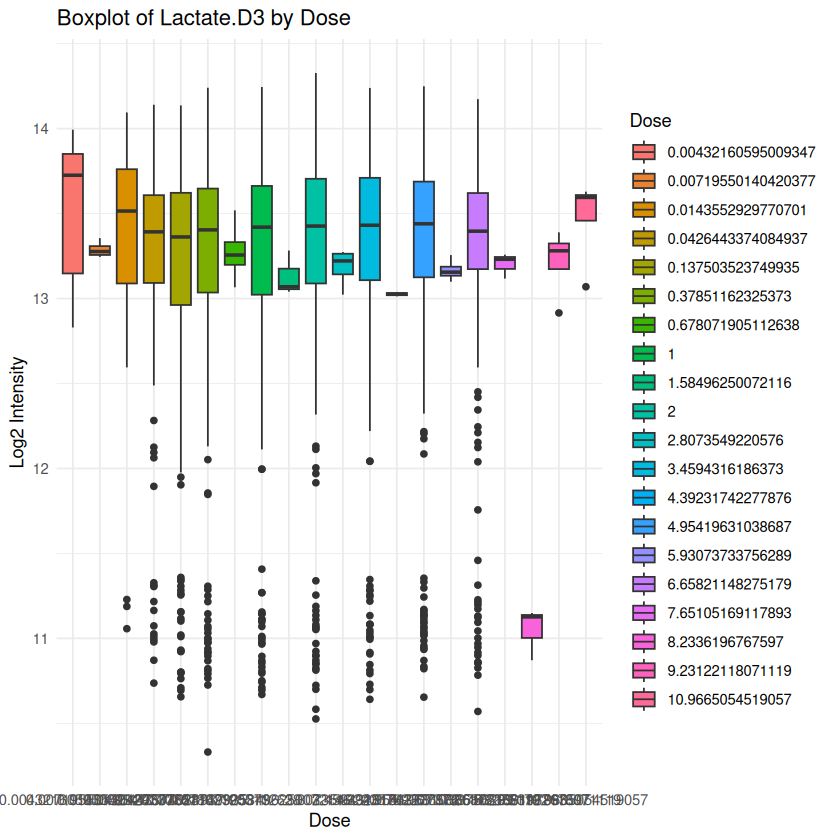

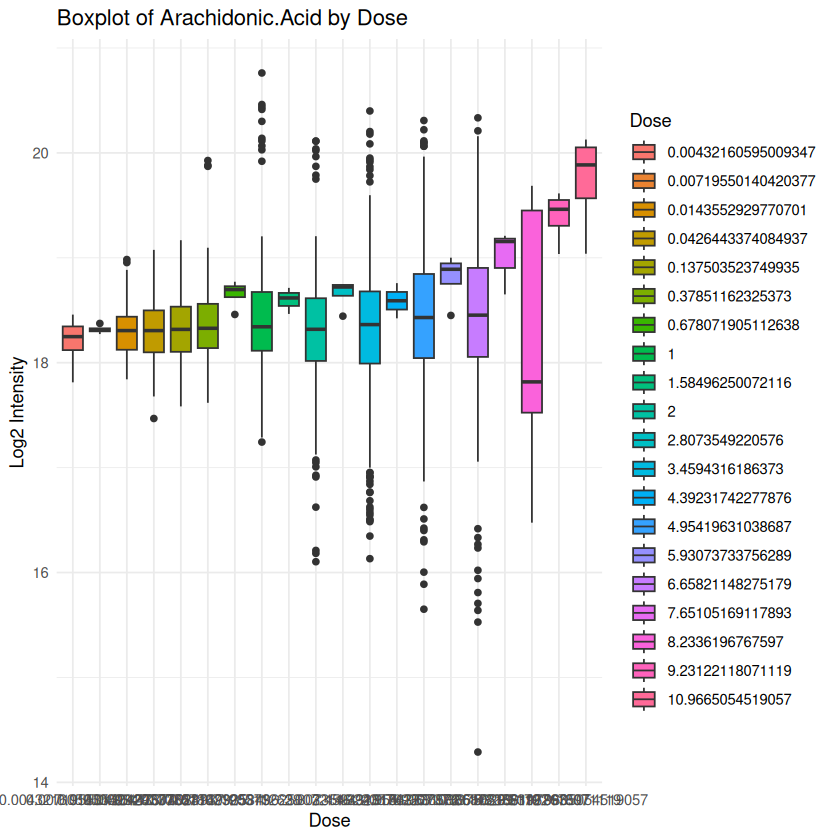

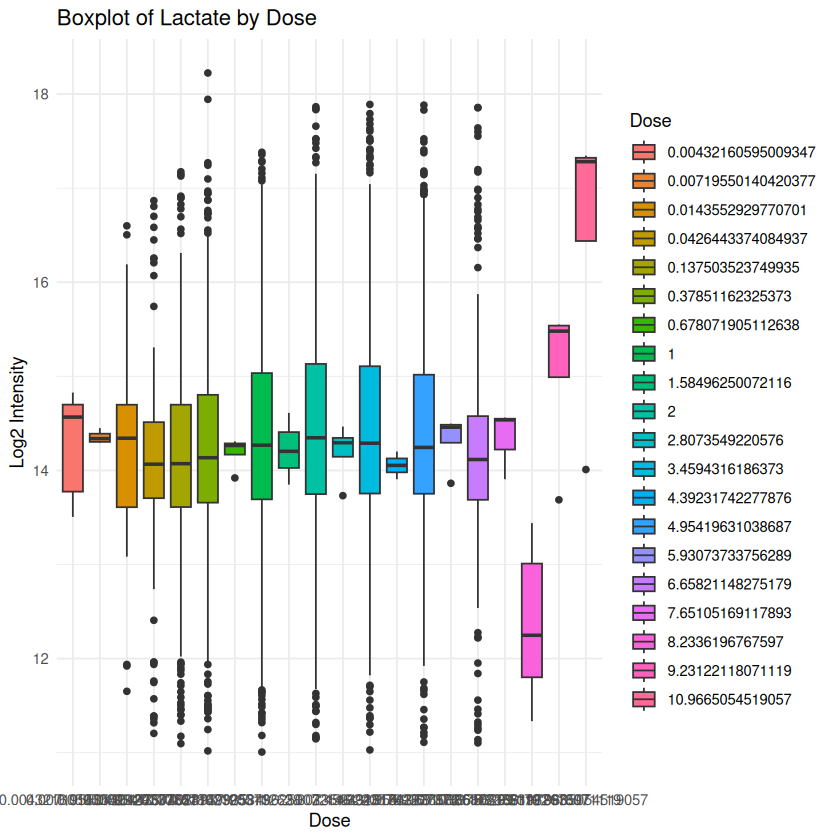

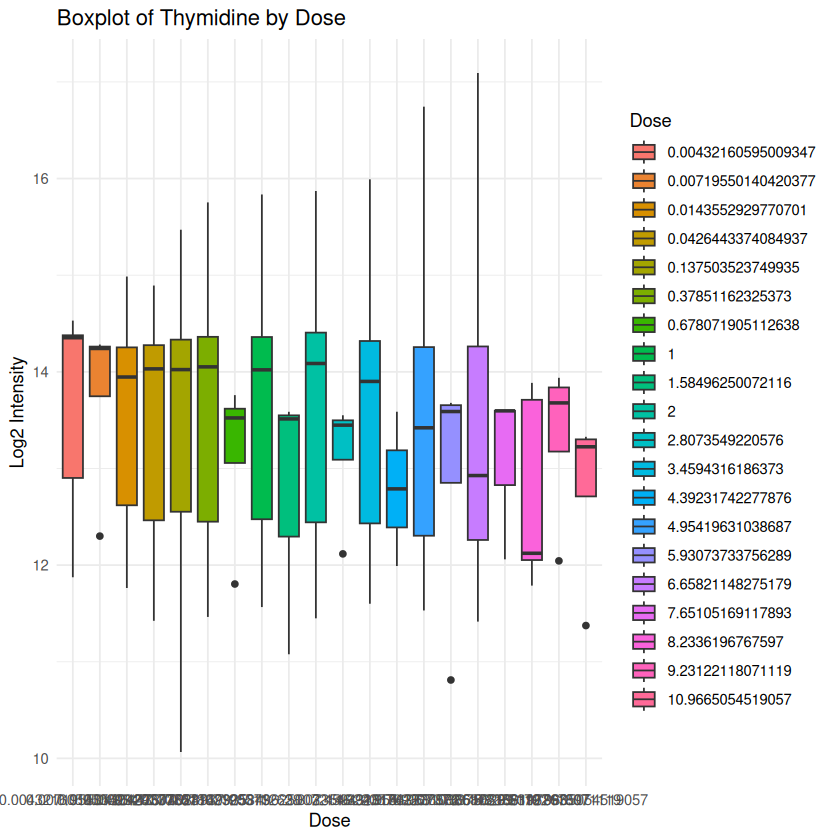

In [5]:
# Select metabolites (numeric columns except metadata)
metabolites <- data_clean %>%
  select(where(is.numeric), -Dose) %>%
  names()

# ANOVA across Compounds
anova_compound_results <- map_dfr(metabolites, function(met) {
  formula <- as.formula(paste(met, "~ Compound"))
  test <- aov(formula, data = data_clean)
  tidy(test) %>%
    filter(term == "Compound") %>%
    mutate(Metabolite = met)
}) %>%
  select(Metabolite, statistic, p.value) %>%
  mutate(p.adjusted = p.adjust(p.value, method = "BH"))

# Filter significant results
anova_compound_significant <- anova_compound_results %>%
  filter(p.adjusted < 0.05) %>%
  arrange(p.adjusted)

# Print results
print("ANOVA results (Compound):")
print(anova_compound_results)
print("Significant metabolites (p.adjusted < 0.05):")
print(anova_compound_significant)

# Visualize significant metabolites
if (nrow(anova_compound_significant) > 0) {
  for (met in anova_compound_significant$Metabolite) {
    p <- ggplot(data_clean, aes(x = Compound, y = .data[[met]], fill = Compound)) +
      geom_boxplot() +
      labs(title = paste("Boxplot of", met, "by Compound"),
           y = "Log2 Intensity", x = "Compound") +
      theme_minimal() +
      theme(axis.text.x = element_text(angle = 45, hjust = 1))
    print(p)
  }
} else {
  print("No significant metabolites found for Compound.")
}

# ANOVA across Dose (if Dose is categorical)
data_clean <- data_clean %>% mutate(Dose = as.factor(Dose))
anova_dose_results <- map_dfr(metabolites, function(met) {
  formula <- as.formula(paste(met, "~ Dose"))
  test <- aov(formula, data = data_clean)
  tidy(test) %>%
    filter(term == "Dose") %>%
    mutate(Metabolite = met)
}) %>%
  select(Metabolite, statistic, p.value) %>%
  mutate(p.adjusted = p.adjust(p.value, method = "BH"))

# Filter significant results
anova_dose_significant <- anova_dose_results %>%
  filter(p.adjusted < 0.05) %>%
  arrange(p.adjusted)

# Print results
print("ANOVA results (Dose):")
print(anova_dose_results)
print("Significant metabolites (p.adjusted < 0.05):")
print(anova_dose_significant)

# Visualize significant metabolites
if (nrow(anova_dose_significant) > 0) {
  for (met in anova_dose_significant$Metabolite) {
    p <- ggplot(data_clean, aes(x = Dose, y = .data[[met]], fill = Dose)) +
      geom_boxplot() +
      labs(title = paste("Boxplot of", met, "by Dose"),
           y = "Log2 Intensity", x = "Dose") +
      theme_minimal()
    print(p)
  }
} else {
  print("No significant metabolites found for Dose.")
}

## Step 4: Chi-Square Test for Categorical Associations

We perform a chi-square test to examine the association between `Effect` (Cardiotoxic vs. Non) and `SampleType` (e.g., cells vs. media).

[1] "Contingency table (Effect vs. SampleType):"
             
              cells media
  Non           576   239
  Cardiotoxic  1009   417
[1] "Chi-square test results:"

	Pearson's Chi-squared test with Yates' continuity correction

data:  contingency_table
X-squared = 8.8092e-30, df = 1, p-value = 1



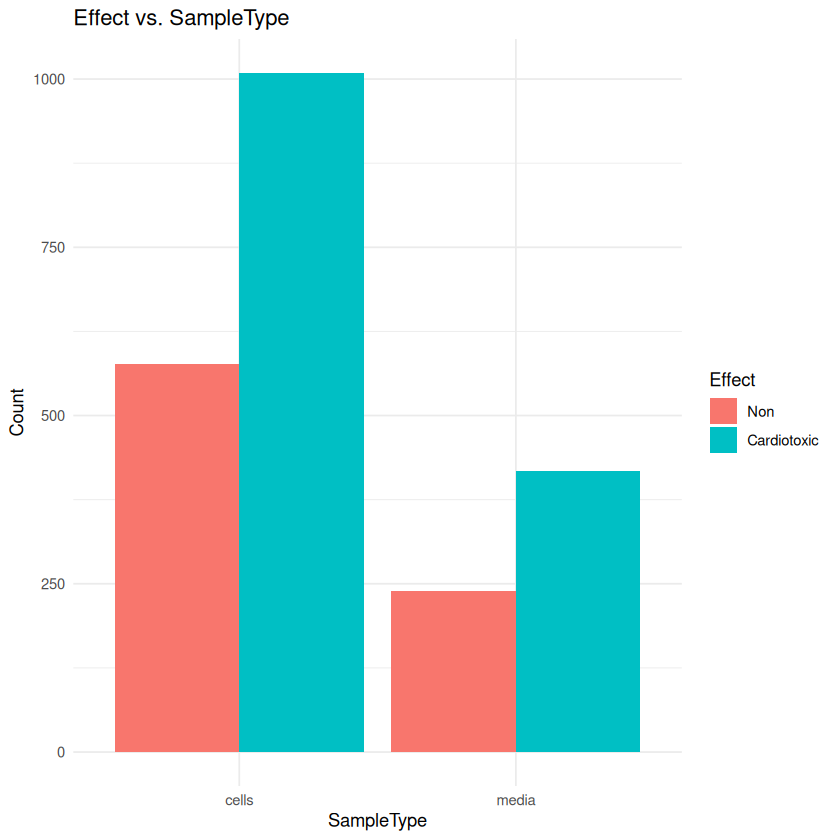

In [6]:
# Create contingency table
contingency_table <- table(data_clean$Effect, data_clean$SampleType)
print("Contingency table (Effect vs. SampleType):")
print(contingency_table)

# Perform chi-square test
chi_test <- chisq.test(contingency_table)
print("Chi-square test results:")
print(chi_test)

# Visualize contingency table
contingency_df <- as.data.frame(contingency_table)
colnames(contingency_df) <- c("Effect", "SampleType", "Count")
ggplot(contingency_df, aes(x = SampleType, y = Count, fill = Effect)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(title = "Effect vs. SampleType", x = "SampleType", y = "Count") +
  theme_minimal()

## Step 5: Save Results

We save the statistical test results for further analysis.

In [7]:
# Save t-test results (if performed)
if (exists("t_test_results")) {
  write.csv(t_test_results, "t_test_results.csv", row.names = FALSE)
  write.csv(t_test_significant, "t_test_significant.csv", row.names = FALSE)
} else {
  print("T-test results not saved because Effect does not have two levels.")
}

# Save ANOVA results
write.csv(anova_compound_results, "anova_compound_results.csv", row.names = FALSE)
write.csv(anova_compound_significant, "anova_compound_significant.csv", row.names = FALSE)
write.csv(anova_dose_results, "anova_dose_results.csv", row.names = FALSE)
write.csv(anova_dose_significant, "anova_dose_significant.csv", row.names = FALSE)

# Save chi-square results
chi_results <- data.frame(
  Statistic = chi_test$statistic,
  P.value = chi_test$p.value,
  Df = chi_test$parameter
)
write.csv(chi_results, "chi_square_results.csv", row.names = FALSE)
write.csv(contingency_table, "contingency_table.csv")